## Dataset creation

### Source Dataset : BraTS 2020

### earlier attempts :
- Sampled n slices in each plane for all four modalities.
- Models did not perform well + complex pipelines

### this attempt :
- Sample n% in each plane for only *t1ce* and *flair*


In [27]:
import random
import matplotlib.pyplot as plt
import os
import numpy as np
import nibabel as nib
from PIL import Image
from tqdm import tqdm

Load a NIfTI file and return the numpy array and affine


In [38]:
def load_nii(file_path):
    nii = nib.load(file_path)
    return nii.get_fdata(), nii.affine

 For a given plane, crop only along the sampling axis by trim_percentage.
    plane: 'sagittal', 'coronal', or 'axial'

In [39]:
def trim_volume(volume, trim_percentage, plane):
    axis = {'sagittal': 0, 'coronal': 1, 'axial': 2}[plane]
    trim_size = int(volume.shape[axis] * trim_percentage)
    indices = list(range(trim_size, volume.shape[axis] - trim_size))
    return np.take(volume, indices, axis=axis)

Sample indices along one axis with a distribution that covers edges.

In [40]:
def sample_indices(num_slices, t):

    num_samples = max(1, int(num_slices * t))

    indices = np.random.normal(loc=num_slices / 2, scale=num_slices / 5, size=num_samples).astype(int)
    indices = np.clip(indices, 0, num_slices - 1)
    indices = np.unique(indices)
    return np.sort(indices)

Normalize a numpy 2D array to uint8 (0–255).


In [41]:
def normalize_to_uint8(slice_data):
    min_val, max_val = np.min(slice_data), np.max(slice_data)
    if max_val == min_val:
        return np.zeros_like(slice_data, dtype=np.uint8)
    norm = (slice_data - min_val) / (max_val - min_val)
    return (norm * 255).astype(np.uint8)

Convert segmentation with 4 classes to grayscale mapping.

In [42]:
def seg_to_gray(slice_data):
    mapping = {0: 0, 1: 85, 2: 170, 4: 255}
    out = np.zeros_like(slice_data, dtype=np.uint8)
    for k, v in mapping.items():
        out[slice_data == k] = v
    return out

Save sampled slices into grayscale PNGs under out_dir/modality.

In [43]:
def save_slices(sampled_slices, out_dir, case_name, modality, is_seg=False):

    os.makedirs(out_dir, exist_ok=True)
    for plane, idx, slice_2d in sampled_slices:
        if is_seg:
            img_array = seg_to_gray(slice_2d)
        else:
            img_array = normalize_to_uint8(slice_2d)
        img = Image.fromarray(img_array, mode='L')
        filename = f"{case_name}_{modality}_{plane}_{idx}.png"
        img.save(os.path.join(out_dir, filename))

Process all patients: for each plane, trim along that plane,
sample slices, and save. Slices are aligned across modalities per plane.

In [44]:
def process_all_cases(root_dir, out_root="sampled_pngs", trim_perc=(0.20, 0.20, 0.10), t=0.1 ):

    os.makedirs(out_root, exist_ok=True)
    case_dirs = [os.path.join(root_dir, d)
                 for d in os.listdir(root_dir)
                 if os.path.isdir(os.path.join(root_dir, d))]

    planes = ['sagittal', 'coronal', 'axial']

    for case_dir in tqdm(case_dirs, desc="Processing patients"):
        case_name = os.path.basename(case_dir)
        files = {
            'flair': (f"{case_name}_flair.nii", False),
            't1ce': (f"{case_name}_t1ce.nii", False),
            'seg': (f"{case_name}_seg.nii", True)
        }

        vols = {}
        for modality, (fname, is_seg) in files.items():
            path = os.path.join(case_dir, fname)
            if not os.path.exists(path):
                print(f"[WARNING] Missing: {path}")
                continue
            vol, _ = load_nii(path)
            vols[modality] = vol

        if not vols:
            print(f"[WARNING] No volumes for {case_name}, skipping...")
            continue

        # FIX: sample indices once per plane, apply to all modalities
        for plane, perc in zip(planes, trim_perc):
            # pick reference modality for sampling indices
            ref_modality = list(vols.keys())[0]
            trimmed_ref_vol = trim_volume(vols[ref_modality], perc, plane)
            axis = {'sagittal': 0, 'coronal': 1, 'axial': 2}[plane]
            num_slices = trimmed_ref_vol.shape[axis]
            sampled_indices = sample_indices(num_slices, t)

            for modality, vol in vols.items():
                trimmed_vol = trim_volume(vol, perc, plane)
                sampled_slices = []
                for idx in sampled_indices:
                    slice_2d = np.take(trimmed_vol, idx, axis=axis)
                    sampled_slices.append((plane, idx, slice_2d))
                modality_out_dir = os.path.join(out_root, modality)
                save_slices(sampled_slices, modality_out_dir,
                            case_name, modality,
                            is_seg=(modality == 'seg'))

    print("[INFO] All cases processed.")

In [28]:
base_root = r"..\data\MICCAI_BraTS2020_TrainingData"
output_root = r"..\data\sampled_pngs"
process_all_cases(root_dir=base_root,
                  out_root=output_root,
                  t=0.30)

Processing patients: 100%|██████████| 369/369 [18:17<00:00,  2.97s/it]

[INFO] All cases processed.


Extract patient ID, plane, and slice index from filename.

In [36]:
def parse_filename(fname):

    parts = fname.replace('.png', '').split('_')
    patient_id = '_'.join(parts[:3])  # BraTS20_Training_001
    plane = parts[4]                  # axial
    slice_idx = parts[5]              # 9
    return patient_id, plane, slice_idx

 Print number of PNG files in each modality folder


In [ ]:
def count_files_per_modality(root_dir, modalities=("flair", "t1ce", "seg")):

    counts = {}
    for modality in modalities:
        folder = os.path.join(root_dir, modality)
        files = [f for f in os.listdir(folder) if f.lower().endswith('.png')]
        counts[modality] = len(files)
        print(f"[INFO] {modality}: {len(files)} files")
    return counts

Display n_samples slices from the first modality and match corresponding slices from other modalities by patient ID, plane, and slice index.

In [ ]:
def sanity_check_triplets(root_dir, n_samples=3, modalities=("flair", "t1ce", "seg")):

    ref_folder = os.path.join(root_dir, modalities[0])
    all_files = [f for f in os.listdir(ref_folder) if f.lower().endswith('.png')]
    if not all_files:
        print(f"[ERROR] No PNG files found in {ref_folder}")
        return

    n_samples = min(n_samples, len(all_files))
    random_files = random.sample(all_files, n_samples)

    for random_file in random_files:
        patient_id, plane, slice_idx = parse_filename(random_file)
        print(f"[INFO] Slice: {random_file} | Patient: {patient_id} | Plane: {plane} | Slice: {slice_idx}")

        fig, axes = plt.subplots(1, len(modalities), figsize=(4 * len(modalities), 4))
        for ax, modality in zip(axes, modalities):
            modality_folder = os.path.join(root_dir, modality)
            matched_file = None
            for f in os.listdir(modality_folder):
                p, pl, s = parse_filename(f)
                if p == patient_id and pl == plane and s == slice_idx:
                    matched_file = f
                    break

            if not matched_file:
                ax.set_title(f"{modality}: MISSING", fontsize=8)
                ax.axis('off')
                continue

            img_path = os.path.join(modality_folder, matched_file)
            img = Image.open(img_path).convert("L")
            ax.imshow(img, cmap='gray', vmin=0, vmax=255)
            ax.set_title(modality, fontsize=10)
            ax.axis('off')

        plt.suptitle(f"Triplet view for slice: {random_file[-30:]}")
        plt.tight_layout()
        plt.show()

[INFO] flair: 37242 files
[INFO] t1ce: 37242 files
[INFO] seg: 37242 files
[INFO] Slice: BraTS20_Training_201_flair_coronal_76.png | Patient: BraTS20_Training_201 | Plane: coronal | Slice: 76


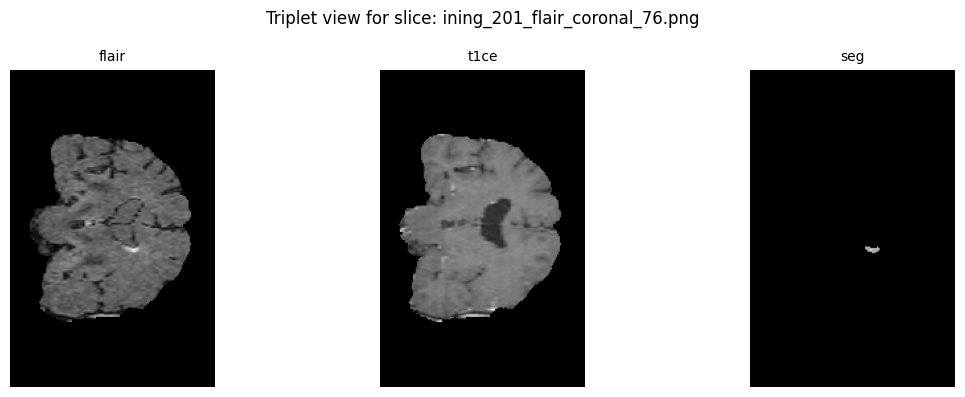

[INFO] Slice: BraTS20_Training_146_flair_coronal_77.png | Patient: BraTS20_Training_146 | Plane: coronal | Slice: 77


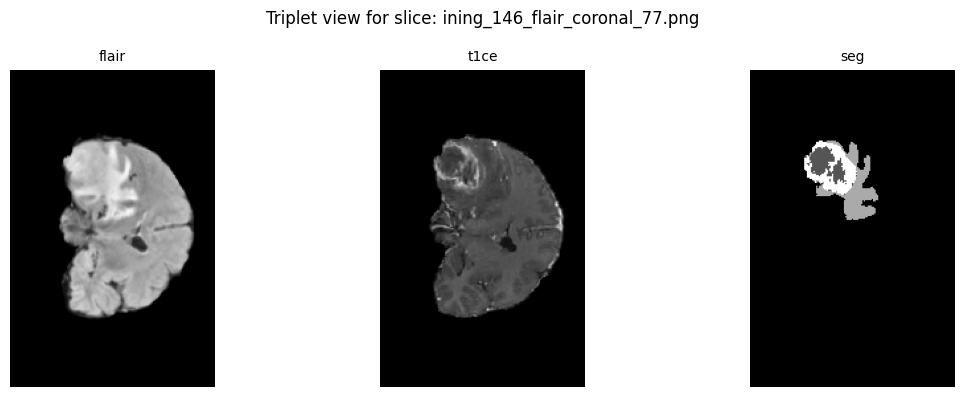

[INFO] Slice: BraTS20_Training_245_flair_axial_55.png | Patient: BraTS20_Training_245 | Plane: axial | Slice: 55


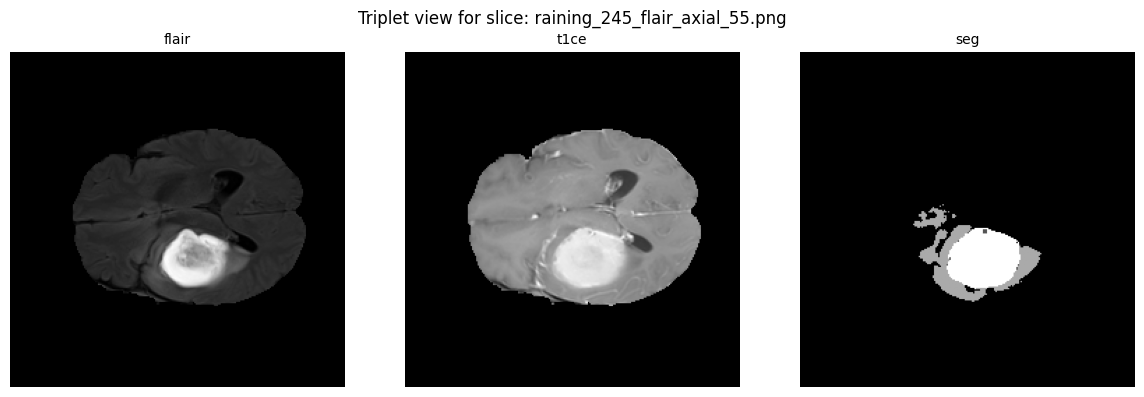

[INFO] Slice: BraTS20_Training_148_flair_axial_109.png | Patient: BraTS20_Training_148 | Plane: axial | Slice: 109


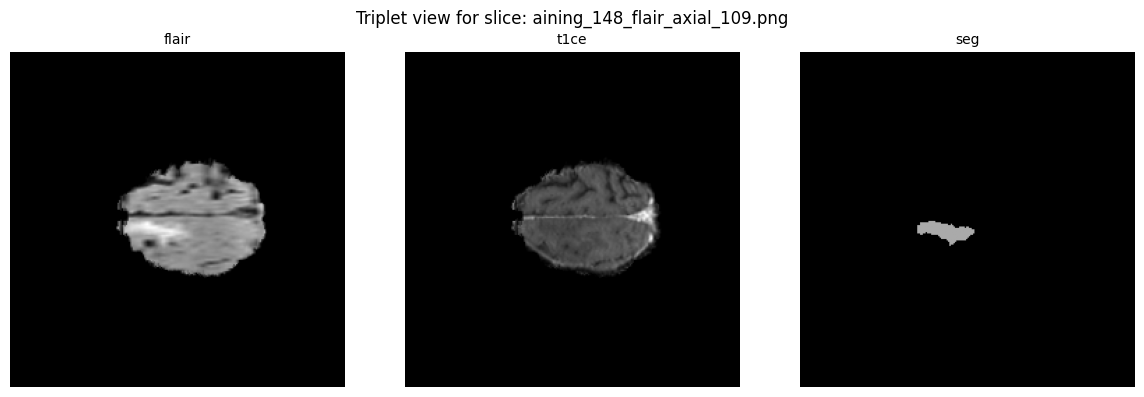

[INFO] Slice: BraTS20_Training_248_flair_axial_124.png | Patient: BraTS20_Training_248 | Plane: axial | Slice: 124


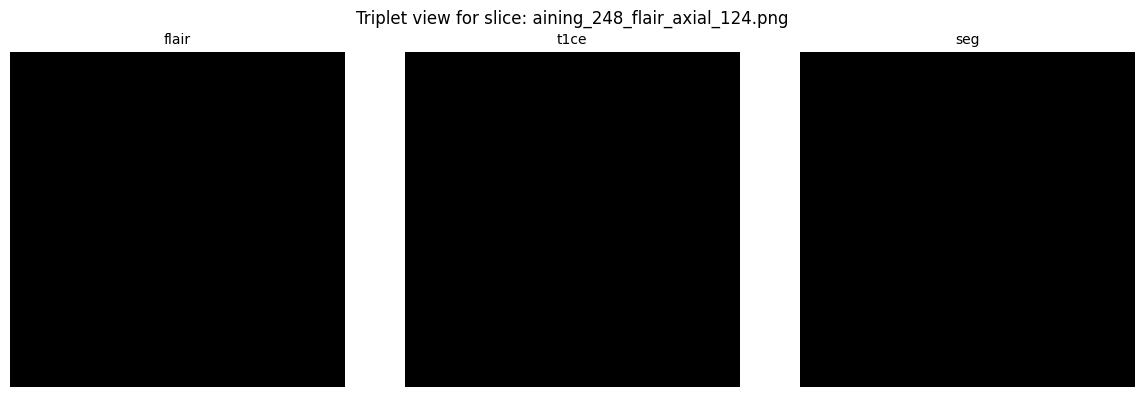

In [37]:
root_dir = r"..\data\sampled_pngs"

# Count files in each modality
count_files_per_modality(root_dir)

# Display 5 random slices side-by-side
sanity_check_triplets(root_dir, n_samples=5)
